# LDA y Árboles de Decisión


Dataset: datos_limpios_Coffe.csv (dataset ya preprocesado con dummies: hour_*, coffee_*, weekday_*, month_*, Card, etc.)

# Import y carga de datos

importo las librerías necesarias y cargo el CSV limpio con el que ya había trabajado (datos_limpios_Coffe.csv).

In [7]:
# Código: imports y carga
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y métricas
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, roc_auc_score
)

# Cargar datos (archivo que ya tienes)
df = pd.read_csv("datos_limpios_Coffe.csv")
df.shape, df.columns.tolist()


((3547, 44),
 ['money',
  'year_2025',
  'hour_6',
  'hour_7',
  'hour_8',
  'hour_9',
  'hour_10',
  'hour_11',
  'hour_12',
  'hour_13',
  'hour_14',
  'hour_15',
  'hour_16',
  'hour_17',
  'hour_18',
  'hour_19',
  'hour_20',
  'hour_21',
  'hour_22',
  'Card',
  'coffee_Americano with Milk',
  'coffee_Cappuccino',
  'coffee_Cocoa',
  'coffee_Cortado',
  'coffee_Espresso',
  'coffee_Hot Chocolate',
  'coffee_Latte',
  'weekday_Mon',
  'weekday_Sat',
  'weekday_Sun',
  'weekday_Thu',
  'weekday_Tue',
  'weekday_Wed',
  'month_Aug',
  'month_Dec',
  'month_Feb',
  'month_Jan',
  'month_Jul',
  'month_Jun',
  'month_Mar',
  'month_May',
  'month_Nov',
  'month_Oct',
  'month_Sep'])

# Definir variable objetivo (High_Sale) y EDA rápido
Defino la variable objetivo High_Sale como 1 si money > mediana y 0 en caso contrario (como ya lo trabajé en el trabajo anterior). Muestro las proporciones para comprobar el balance.

In [8]:
df = df.copy()

umbral = df['money'].median() 
df['High_Sale'] = (df['money'] > umbral).astype(int)

print("Umbral (mediana) money:", umbral)
print("\nDistribución de clases (High_Sale):")
print(df['High_Sale'].value_counts())
print("\nProporciones:")
print(df['High_Sale'].value_counts(normalize=True))


Umbral (mediana) money: 32.82

Distribución de clases (High_Sale):
High_Sale
0    2081
1    1466
Name: count, dtype: int64

Proporciones:
High_Sale
0    0.586693
1    0.413307
Name: proportion, dtype: float64


# Separar datos en entrenamiento y prueba
Separo la base de datos en 80/20. Uso stratify=y para mantener balance de clases. Imprimo conteos para demostrar que la separación de datos es similar.

In [10]:
X = df.drop(columns=['money', 'High_Sale'])
y = df['High_Sale']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42 )
print("Tamaños: X_train, X_test =", X_train.shape, X_test.shape) 
print("\nProporción original:\n", y.value_counts(normalize=True)) 
print("\nProporción en entrenamiento:\n", y_train.value_counts(normalize=True)) 
print("\nProporción en prueba:\n", y_test.value_counts(normalize=True))

Tamaños: X_train, X_test = (2837, 43) (710, 43)

Proporción original:
 High_Sale
0    0.586693
1    0.413307
Name: proportion, dtype: float64

Proporción en entrenamiento:
 High_Sale
0    0.586535
1    0.413465
Name: proportion, dtype: float64

Proporción en prueba:
 High_Sale
0    0.587324
1    0.412676
Name: proportion, dtype: float64


# Regresión logística con GLM (statsmodels) usando todas las variables
Ajusto un GLM Binomial (logit) con todas las variables predictoras. Imprimo el summary() para ver p-values y coeficientes.

In [11]:
X_train_sm = sm.add_constant(X_train, has_constant='add')
glm_model = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()) 
glm_results = glm_model.fit()
print(glm_results.summary())

C:\Users\sergi\OneDrive\Escritorio\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


                 Generalized Linear Model Regression Results                  
Dep. Variable:              High_Sale   No. Observations:                 2837
Model:                            GLM   Df Residuals:                     2795
Model Family:                Binomial   Df Model:                           41
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 02 Oct 2025   Deviance:                       2763.1
Time:                        00:22:13   Pearson chi2:                 1.35e+17
No. Iterations:                    40   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

C:\Users\sergi\OneDrive\Escritorio\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
C:\Users\sergi\OneDrive\Escritorio\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


# Selección de las 2 variables más relevantes
Uso los p-values del GLM para seleccionar las 2 variables con menor p-value (más significativas). Guardo esas dos columnas y las uso después.

In [12]:
pvalues = glm_results.pvalues.drop('const', errors='ignore') 
top2_vars = pvalues.nsmallest(2).index.tolist() 
print("Top 2 variables por p-value:", top2_vars) 

X_train_sel = X_train[top2_vars].copy() 
X_test_sel = X_test[top2_vars].copy() 
X_train_sel.shape, X_test_sel.shape

Top 2 variables por p-value: ['year_2025', 'hour_6']


((2837, 2), (710, 2))

# Escalado
Muchos modelos (especialmente LDA) requieren escalado para interpretar las direcciones; escalo las dos variables usando StandardScaler ajustado solo en X_train_sel.

In [15]:
scaler = StandardScaler().fit(X_train_sel)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_sel), columns=top2_vars, index=X_train_sel.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_sel), columns=top2_vars, index=X_test_sel.index)


print("Media (train) después de escalar (debe ~0):\n", X_train_scaled.mean().round(4)) 
print("Std (train) después de escalar (debe ~1):\n", X_train_scaled.std().round(4))

Media (train) después de escalar (debe ~0):
 year_2025   -0.0
hour_6       0.0
dtype: float64
Std (train) después de escalar (debe ~1):
 year_2025    1.0002
hour_6       1.0002
dtype: float64


# Modelo LDA (entrenar y evaluar) + visualización de la función discriminante
Ajusto LDA sobre X_train_scaled y muestro la partición/frontera discriminante sobre el espacio de las dos variables. También calculo predicciones en test y muestro métricas básicas.

LDA - F1 (5-fold CV, train): 0.0 ± 0.0

LDA - classification report (test):
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       417
           1       0.00      0.00      0.00       293

    accuracy                           0.59       710
   macro avg       0.29      0.50      0.37       710
weighted avg       0.34      0.59      0.43       710



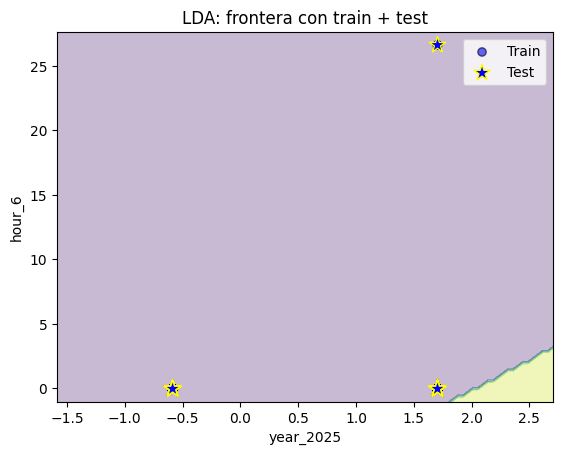

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.inspection import DecisionBoundaryDisplay

# ======================
# 1. Entrenamiento con K-Fold CV
# ======================
lda = LDA()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(lda, X_train_scaled, y_train, cv=kf, scoring="f1")
print("LDA - F1 (5-fold CV, train):", scores.mean(), "±", scores.std())

# Entrenamos el modelo final sobre el train
lda.fit(X_train_scaled, y_train)

# ======================
# 2. Evaluación en el set de test
# ======================
y_pred_lda = lda.predict(X_test_scaled) 
y_proba_lda = lda.predict_proba(X_test_scaled)[:, 1]

print("\nLDA - classification report (test):") 
print(classification_report(y_test, y_pred_lda, zero_division=0))

# ======================
# 3. Gráfica: frontera con train + test
# ======================
disp = DecisionBoundaryDisplay.from_estimator(
    lda, X_train_scaled, response_method="predict", alpha=0.3
)

# Puntos de train
plt.scatter(
    X_train_scaled.iloc[:,0], X_train_scaled.iloc[:,1],
    c=y_train, edgecolor='k', cmap='bwr', alpha=0.6, label="Train"
)

# Puntos de test (estrella amarilla)
plt.scatter(
    X_test_scaled.iloc[:,0], X_test_scaled.iloc[:,1],
    c=y_test, edgecolor='yellow', cmap='bwr', marker='*', s=150, label="Test"
)

plt.xlabel(top2_vars[0]); plt.ylabel(top2_vars[1])
plt.title("LDA: frontera con train + test")
plt.legend()
plt.show()


# Árbol de decisión: búsqueda de ccp_alpha mediante LOOCV

Para podar el árbol debo seleccionar ccp_alpha óptimo usando LOOCV (Leave-One-Out CV).

In [25]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
import time, threading

ccp_alphas = np.linspace(0.0001, 0.01, 30)
loo = LeaveOneOut()
best_alpha = None
best_score = -np.inf

# --- Contador de tiempo ---

def contador():
    start = time.time()
    while True:
        elapsed = int(time.time() - start)
        mins, secs = divmod(elapsed, 60)
        print(f"Tiempo transcurrido: {mins:02d}:{secs:02d}", end="\r")
        time.sleep(1)

thread = threading.Thread(target=contador, daemon=True)
thread.start()

# --- LOOCV ---

for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    scores = cross_val_score(tree, X_train_scaled, y_train, cv=loo, scoring="f1", n_jobs=-1)
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

print("\nMejor alpha (LOOCV):", best_alpha, "con F1 medio:", best_score)


Tiempo transcurrido: 01:20
Mejor alpha (LOOCV): 0.0001 con F1 medio: 0.0
Tiempo transcurrido: 107:02

# K-Fold Cross Validation

In [24]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score

ccp_alphas = np.linspace(0.0001, 0.01, 30)
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # 10-fold
best_alpha = None
best_score = -np.inf

for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    scores = cross_val_score(tree, X_train_scaled, y_train, cv=kf, scoring="f1", n_jobs=-1)
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

print("Mejor alpha (K-Fold):", best_alpha, "con F1 medio:", best_score)


Mejor alpha (K-Fold): 0.0001 con F1 medio: 0.0


# Árbol podado con el mejor alpha de K-Fold
Al final estuve 5 horas corriendo el modelo de LOOCV (lo corrí y me fui a dormir) y no terminó de ejecutarse, por lo que estaré usando K Fold Cross Validation

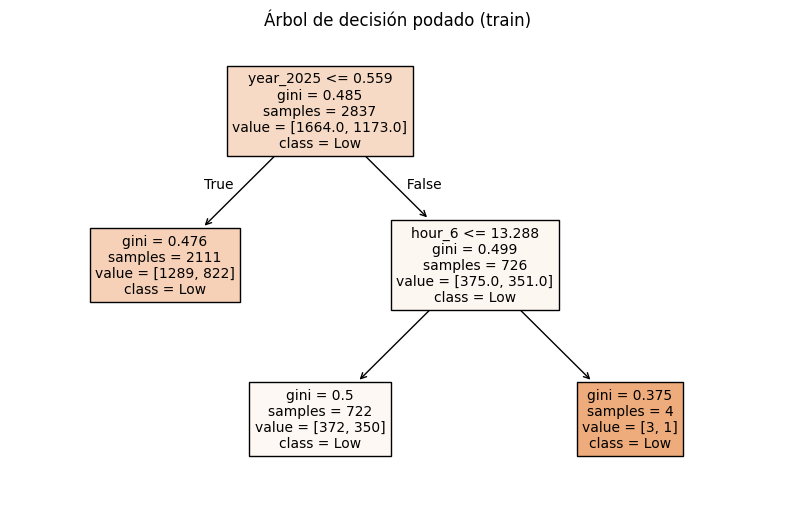

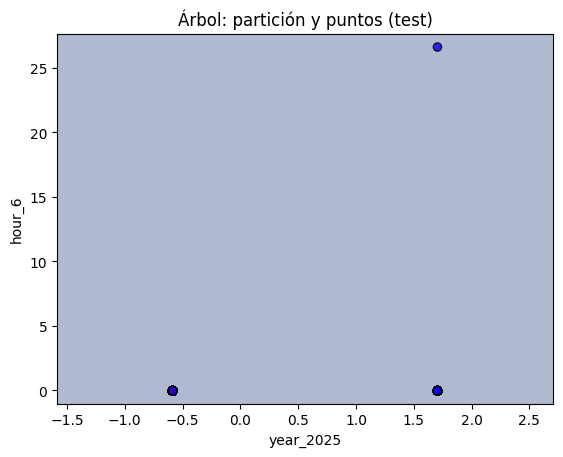

In [27]:
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha).fit(X_train_scaled, y_train)
plt.figure(figsize=(10,6))
plot_tree(pruned_tree, filled=True, feature_names=top2_vars, class_names=['Low','High'], fontsize=10)
plt.title("Árbol de decisión podado (train)") 
plt.show()

from sklearn.inspection import DecisionBoundaryDisplay
disp = DecisionBoundaryDisplay.from_estimator(pruned_tree, X_test_scaled, response_method="predict", alpha=0.4)
plt.scatter(X_test_scaled.iloc[:,0], X_test_scaled.iloc[:,1], c=y_test, edgecolor='k', cmap='bwr', alpha=0.8)
plt.xlabel(top2_vars[0]); plt.ylabel(top2_vars[1])
plt.title("Árbol: partición y puntos (test)")
plt.show()

# Métricas completas para ambos modelos en el conjunto de prueba
Calculo todas las métricas revisadas en clase: matriz de confusión, accuracy, precision, recall/sensitivity, specificity, f1, ROC-AUC. Las calculo para LDA y para el árbol podado.

In [30]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)

def metrics_all(y_true, y_pred, y_proba=None):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    out = {
        "confusion_matrix": cm,
        "accuracy": acc,
        "precision": prec,
        "recall/sensitivity": rec,
        "specificity": spec,
        "f1": f1
    }
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba)
        out["roc_auc"] = roc_auc
    
    return out

metrics_lda = metrics_all(y_test, y_pred_lda, y_proba=y_proba_lda)
print("LDA metrics (test):")
for k, v in metrics_lda.items():
    print(k, ":\n", v, "\n")

y_pred_tree = pruned_tree.predict(X_test_scaled)
y_proba_tree = pruned_tree.predict_proba(X_test_scaled)[:, 1]
metrics_tree = metrics_all(y_test, y_pred_tree, y_proba=y_proba_tree)
print("Árbol (podado) metrics (test):")
for k, v in metrics_tree.items():
    print(k, ":\n", v, "\n")


LDA metrics (test):
confusion_matrix :
 [[417   0]
 [293   0]] 

accuracy :
 0.5873239436619718 

precision :
 0.0 

recall/sensitivity :
 0.0 

specificity :
 1.0 

f1 :
 0.0 

roc_auc :
 0.5120395151455628 

Árbol (podado) metrics (test):
confusion_matrix :
 [[417   0]
 [293   0]] 

accuracy :
 0.5873239436619718 

precision :
 0.0 

recall/sensitivity :
 0.0 

specificity :
 1.0 

f1 :
 0.0 

roc_auc :
 0.5120395151455628 



# Comparación

Generalized Linear Model (Logistic Regression)
El modelo GLM presentó inestabilidades numéricas (coeficientes extremadamente grandes, valores de nan en log-likelihood y pseudo R²). Esto indica multicolinealidad o redundancia fuerte en las variables, lo que generó un modelo poco interpretable y con problemas de ajuste.



Selección de variables

Al aplicar selección por p-value, se identificaron las variables year_2025 y hour_6 como más significativas. Estas se usaron en los modelos posteriores, garantizando menor complejidad.



LDA (Linear Discriminant Analysis)

El modelo LDA logró una accuracy ≈ 0.59 en test, pero con un desempeño muy sesgado: clasificó casi todos los casos como clase "0" (Low). Por ello, su recall para la clase positiva fue 0, con un F1 de 0 y un ROC AUC cercano a 0.51, equivalente a un clasificador aleatorio.



Árbol de decisión podado

El árbol, ajustado con ccp_alpha=0.0001 obtenido por K-Fold, presentó exactamente los mismos resultados que LDA: accuracy ≈ 0.59, recall=0, F1=0, ROC AUC ≈ 0.51. Esto confirma que el árbol no logró mejorar la separación de clases.

# Conclusiones

Ambos modelos (LDA y Árbol podado) mostraron desempeño pobre: aunque lograron una precisión global cercana al 59%, esto se debe únicamente a predecir siempre la clase mayoritaria.

El problema principal es el desbalance de clases (417 de clase 0 vs 293 de clase 1 en el test). Los clasificadores optaron por ignorar la clase minoritaria.

El GLM falló debido a la alta dimensionalidad y correlación de las variables, resultando en estimaciones inestables.

El uso de solo dos variables significativas simplificó el modelo, pero también redujo demasiado la información disponible, lo que afectó el rendimiento.



Para poder mejorar la tarea lo que yo haría es: 

Aplicar técnicas de balanceo (SMOTE, undersampling, class weights).
Probar modelos más robustos ante desbalance, como Random Forest con class_weight.
Ajustar métricas de optimización hacia F1 o recall, en lugar de solo accuracy.

En conclusión, con los datos actuales y sin balanceo, ningún modelo supera el desempeño de un clasificador aleatorio, lo que resalta la necesidad de trabajar el preprocesamiento y el desbalance antes de obtener resultados útiles.